In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from ranger import Ranger
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [3]:
bs = 32

In [5]:
np.random.seed(9) # Set specific seed for images

data = ImageDataBunch.from_folder(
    path = ("train"), # using the actual string location works!
    test = ("../test"),
    valid_pct = 0.15,
    bs = bs,
    ds_tfms = get_transforms(do_flip=True),
    size = 150
    #,resize_method=ResizeMethod.SQUISH
    ).normalize(imagenet_stats)

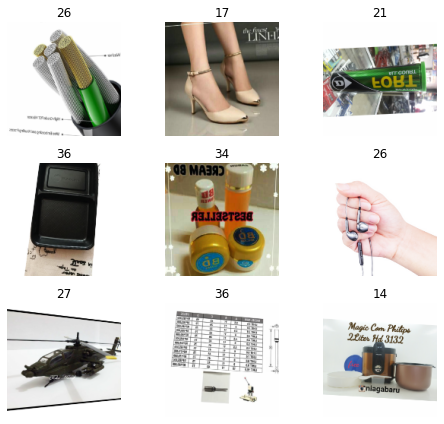

In [6]:
data.show_batch(rows=3, figsize=(7,6))

In [7]:
print(data.classes)
len(data.classes),data.c

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41']


(42, 42)

In [8]:
pd.Series(data.train_ds.y.items.tolist()).value_counts()

27    2321
12    2320
9     2316
3     2315
8     2310
25    2304
30    2300
24    2299
38    2297
26    2294
2     2289
36    2284
31    2281
1     2280
35    2279
39    2278
6     2277
7     2275
14    2275
19    2274
4     2269
5     2266
0     2265
13    2256
40    2255
10    2252
16    2247
21    2235
20    2232
41    2227
15    2214
22    2191
28    2190
34    2173
23    2168
29    1820
32    1818
18    1784
11    1564
37    1477
17    1321
33     492
dtype: int64

In [7]:
top_1 = partial(top_k_accuracy, k=1)
optar = partial(Ranger)

In [8]:
learn = cnn_learner(data, models.resnet50, metrics=[top_1,error_rate], callback_fns=BnFreeze)
#, opt_func = optar

In [9]:
#learn.fit_one_cycle(4)

np.random.seed(9)
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,top_k_accuracy,error_rate,time
0,1.728143,1.483872,0.589132,0.410868,36:42


KeyboardInterrupt: 

In [8]:
learn.freeze()
np.random.seed(9)
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,top_k_accuracy,error_rate,time
0,1.237242,1.099787,0.701797,0.298203,36:46
1,1.301966,1.154139,0.689904,0.310096,43:26
2,1.221390,1.076610,0.704453,0.295547,39:25
3,1.118907,1.019220,0.719383,0.280617,36:47


KeyboardInterrupt: 

In [7]:
learn.load('prod-new-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (89584 items)
x: ImageList
Image (3, 180, 180),Image (3, 180, 180),Image (3, 180, 180),Image (3, 180, 180),Image (3, 180, 180)
y: CategoryList
00,00,00,00,00
Path: train;

Valid: LabelList (15808 items)
x: ImageList
Image (3, 180, 180),Image (3, 180, 180),Image (3, 180, 180),Image (3, 180, 180),Image (3, 180, 180)
y: CategoryList
06,24,12,39,30
Path: train;

Test: LabelList (12192 items)
x: ImageList
Image (3, 180, 180),Image (3, 180, 180),Image (3, 180, 180),Image (3, 180, 180),Image (3, 180, 180)
y: EmptyLabelList
,,,,
Path: train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

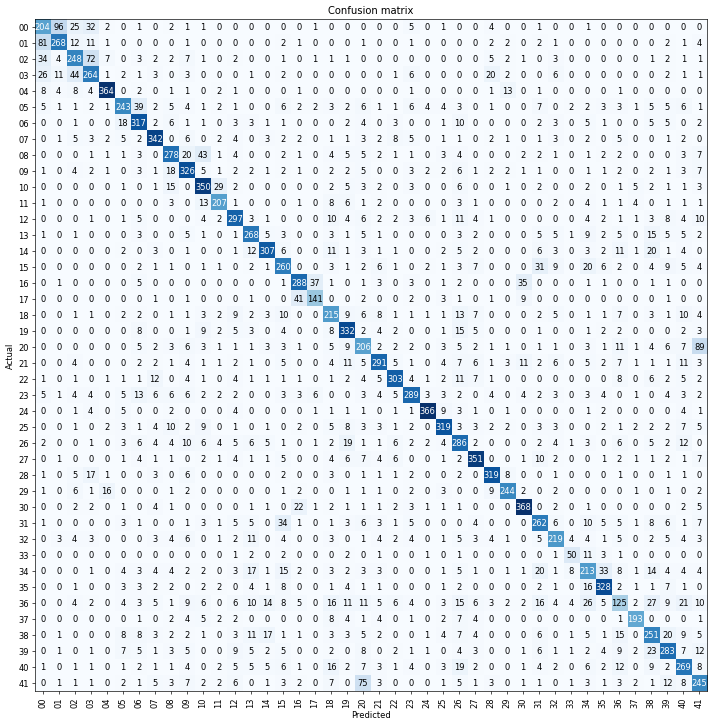

In [15]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

C:\Anaconda\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
C:\Anaconda\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float

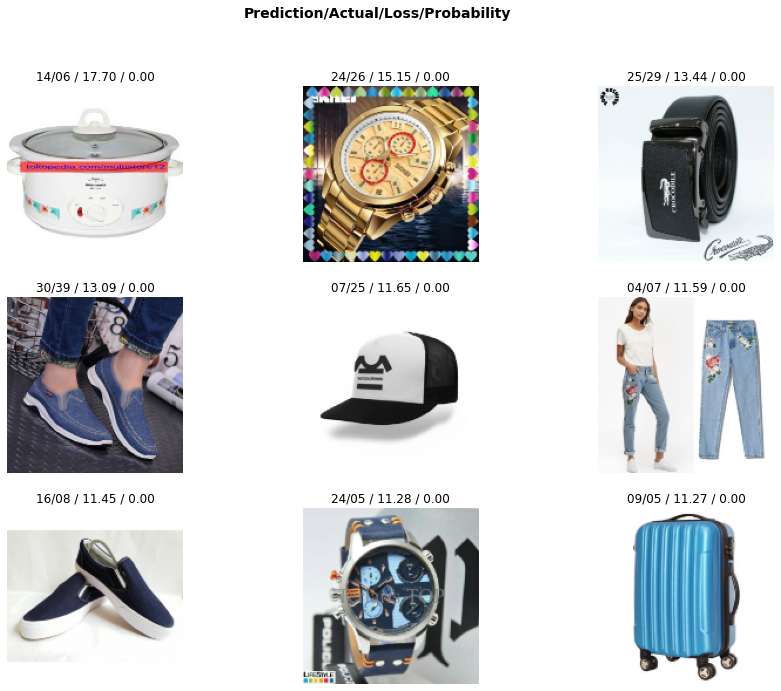

In [16]:
interp.plot_top_losses(9, figsize=(15,11))

In [18]:
interp.most_confused(min_val=30)

[('00', '01', 96),
 ('20', '41', 89),
 ('01', '00', 81),
 ('41', '20', 75),
 ('02', '03', 72),
 ('03', '02', 44),
 ('08', '10', 43),
 ('17', '16', 41),
 ('05', '06', 39),
 ('16', '17', 37),
 ('16', '30', 35),
 ('02', '00', 34),
 ('31', '15', 34),
 ('34', '35', 33),
 ('00', '03', 32),
 ('15', '31', 31)]

# Optimizing the model

set state called


epoch,train_loss,valid_loss,top_k_accuracy,error_rate,time


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


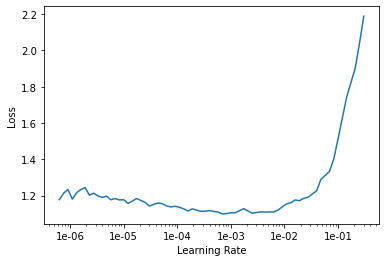

In [7]:
learn.load('prod-ranger-stage-1')
learn.lr_find()
learn.recorder.plot()

In [8]:
learn.unfreeze()
np.random.seed(9)
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-2))

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch,train_loss,valid_loss,top_k_accuracy,error_rate,time
0,1.263350,1.101048,0.696862,0.303138,45:03
1,1.166489,1.063594,0.706604,0.293396,40:08
2,1.131432,1.002171,0.726910,0.273090,37:04
3,0.964411,0.956529,0.737601,0.262399,36:24
4,0.845164,0.929044,0.746584,0.253416,38:04
5,0.755678,0.910324,0.758413,0.241587,38:08
6,0.574368,0.898597,0.766764,0.233236,38:47
7,0.464756,0.920930,0.772204,0.227796,42:35
8,0.373287,0.944558,0.775177,0.224823,37:43
9,0.306409,0.956649,0.774418,0.225582,40:52


In [9]:
learn.save('prod-ranger-stage-2')

In [11]:
learn.unfreeze()
np.random.seed(9)
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-2))

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch,train_loss,valid_loss,top_k_accuracy,error_rate,time
0,0.576353,0.976531,0.757718,0.242282,38:43
1,0.346180,0.960112,0.771508,0.228492,36:47


In [12]:
learn.save('prod-ranger-stage-3')

In [13]:
learn.unfreeze()
np.random.seed(9)
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-2))

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch,train_loss,valid_loss,top_k_accuracy,error_rate,time
0,0.569106,1.104418,0.742535,0.257465,38:06
1,0.464430,1.020443,0.763917,0.236083,36:03
2,0.275491,1.044782,0.771635,0.228365,34:34


In [14]:
learn.save('prod-ranger-stage-4')
#latest

In [7]:
learn.load('prod-ranger-stage-4')
learn.unfreeze()
np.random.seed(9)
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-2))

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch,train_loss,valid_loss,top_k_accuracy,error_rate,time
0,0.472823,1.096839,0.751771,0.248229,41:34
1,0.499229,1.066966,0.752594,0.247406,36:58
2,0.328267,1.106670,0.765498,0.234502,37:40
3,0.189000,1.311776,0.766321,0.233679,36:18


# Cleaning Data

In [10]:
learn.load('prod-ranger-stage-2')


Learner(data=ImageDataBunch;

Train: LabelList (89584 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
00,00,00,00,00
Path: train;

Valid: LabelList (15808 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: CategoryList
06,24,12,39,30
Path: train;

Test: LabelList (12192 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: EmptyLabelList
,,,,
Path: train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(

In [11]:
from fastai.widgets import *

In [15]:
ds, idxs = DatasetFormatter().from_toplosses(learn)


In [22]:
ImageCleaner(ds, idxs, 'train')

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

# Training Cleaned Dataset

In [3]:
df = pd.read_csv('train/cleaned.csv', header='infer')

In [4]:
np.random.seed(9)

data = ImageDataBunch.from_df('train', df, 
    valid_pct = 0.15,
    bs = 32,
    test='../test',                         
    ds_tfms = get_transforms(do_flip=True),
    size = 150).normalize(imagenet_stats)

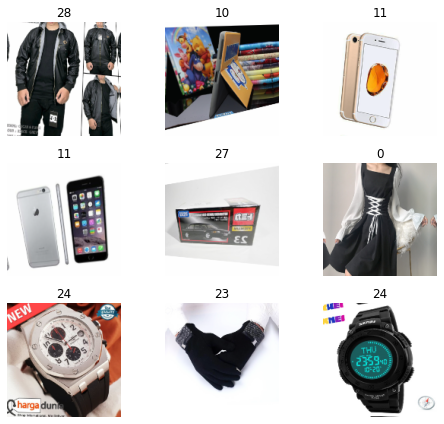

In [6]:
data.show_batch(rows=3, figsize=(7,6))

In [5]:
top_1 = partial(top_k_accuracy, k=1)
optar = partial(Ranger)

In [6]:
learn = cnn_learner(data, models.resnet50, metrics=[top_1,error_rate], opt_func = optar, callback_fns=BnFreeze)
#, opt_func = optar

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [9]:
np.random.seed(9)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,top_k_accuracy,error_rate,time
0,1.706441,1.399165,0.613834,0.386166,34:57
1,1.417134,1.209316,0.660597,0.339403,33:27
2,1.273101,1.107319,0.691397,0.308603,34:48
3,1.200273,1.074295,0.700090,0.299910,30:42


In [10]:
#learn.save('new-prod-ranger-stage-1')

set state called
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch,train_loss,valid_loss,top_k_accuracy,error_rate,time


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


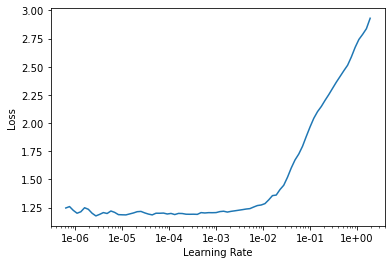

In [9]:
learn.load('new-prod-ranger-stage-1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [7]:
learn.load('new-prod-ranger-stage-1')

learn.unfreeze()
np.random.seed(9)
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-2))

set state called
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch,train_loss,valid_loss,top_k_accuracy,error_rate,time
0,1.254491,1.101618,0.696493,0.303507,28:41
1,1.216646,1.049234,0.710432,0.289568,29:40
2,1.117366,1.004847,0.717776,0.282224,30:38
3,0.982412,0.960604,0.734038,0.265962,32:35
4,0.855531,0.933840,0.744454,0.255546,27:53
5,0.680689,0.903369,0.759817,0.240183,27:04
6,0.543798,0.904559,0.766262,0.233738,27:34
7,0.398364,0.944574,0.770159,0.229841,26:34
8,0.318242,0.977013,0.774805,0.225195,28:04
9,0.283880,0.982242,0.776604,0.223396,27:29


In [9]:
learn.save('new-prod-ranger-stage-2')

In [11]:
learn.unfreeze()
np.random.seed(9)
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-2))

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch,train_loss,valid_loss,top_k_accuracy,error_rate,time
0,0.464139,1.129838,0.745803,0.254197,28:15
1,0.357535,1.065008,0.765737,0.234263,28:26
2,0.227129,1.085787,0.770833,0.229167,28:59


# Output

In [12]:
preds, y = learn.get_preds(DatasetType.Test)

class_score = np.argmax(preds, axis=1)
class_score = class_score.tolist()

ImageId = [os.path.splitext(path)[0] for path in os.listdir('test/test')]

output = pd.DataFrame(zip(ImageId,class_score), columns = (['filename','category'])).sort_values('filename')
output['filename'] = output['filename'] + '.jpg'

testlist = pd.read_csv('test.csv')

output = (output[output['filename'].isin(testlist['filename'])])

output['category'] = output['category'].astype(str).str.zfill(2)

output.to_csv('gab_mago_scl_2_ranger_final2.csv', index = False)